<a href="https://colab.research.google.com/github/MathieuFan22/Mirada-Examen-ML-M2-ISPM/blob/Sariaka/PoketraFinday-Mirada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install --upgrade pip
!pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             f1_score, precision_score, recall_score)

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE

In [46]:
# ============================================
# 2️⃣ CHARGER LES DATASETS (TRAIN ET TEST)
# ============================================

# Gestion du déséquilibre
from imblearn.over_sampling import SMOTE
uploaded_train = files.upload()
train_file = list(uploaded_train.keys())[0]
train_df = pd.read_csv(train_file)

uploaded_test = files.upload()
test_file = list(uploaded_test.keys())[0]
test_df = pd.read_csv(test_file)

Saving train.csv to train (6).csv


Saving test.csv to test (6).csv


In [47]:
# Nettoyer les noms de colonnes
train_df.columns = train_df.columns.str.strip()
test_df.columns = test_df.columns.str.strip()

print(f"✅ Train shape: {train_df.shape}")
print(f"✅ Test shape: {test_df.shape}")

✅ Train shape: (30000, 7)
✅ Test shape: (10000, 6)


In [48]:
# ============================================
# 3️⃣ EDA (EXPLORATORY DATA ANALYSIS)
# ============================================
print("\n" + "="*60)
print("📊 ANALYSE EXPLORATOIRE DES DONNÉES")
print("="*60)

# Informations générales
print("\n🔍 Informations du dataset:")
print(train_df.info())

print("\n📋 Statistiques descriptives:")
print(train_df.describe())

# Valeurs manquantes
print("\n❓ Valeurs manquantes:")
missing = train_df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("✅ Aucune valeur manquante!")

# Distribution de la cible
print("\n🎯 Distribution de la cible (is_fraud):")
fraud_counts = train_df['is_fraud'].value_counts()
fraud_pct = train_df['is_fraud'].value_counts(normalize=True) * 100
print(f"Légitimes (0): {fraud_counts[0]} ({fraud_pct[0]:.2f}%)")
print(f"Fraudes (1):   {fraud_counts[1]} ({fraud_pct[1]:.2f}%)")
print(f"⚠️ Ratio déséquilibre: 1:{int(fraud_counts[0]/fraud_counts[1])}")


📊 ANALYSE EXPLORATOIRE DES DONNÉES

🔍 Informations du dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  30000 non-null  object
 1   step            30000 non-null  int64 
 2   type            30000 non-null  object
 3   amount          30000 non-null  int64 
 4   customer_id     30000 non-null  object
 5   age             30000 non-null  int64 
 6   is_fraud        30000 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.6+ MB
None

📋 Statistiques descriptives:
               step        amount           age      is_fraud
count  30000.000000  3.000000e+04  30000.000000  30000.000000
mean     361.139733  1.474855e+05     34.516800      0.019833
std      207.894173  4.114664e+05     16.067294      0.139430
min        0.000000  1.000000e+02     18.000000      0.000000
25%      180.000000  1.750000e+04    

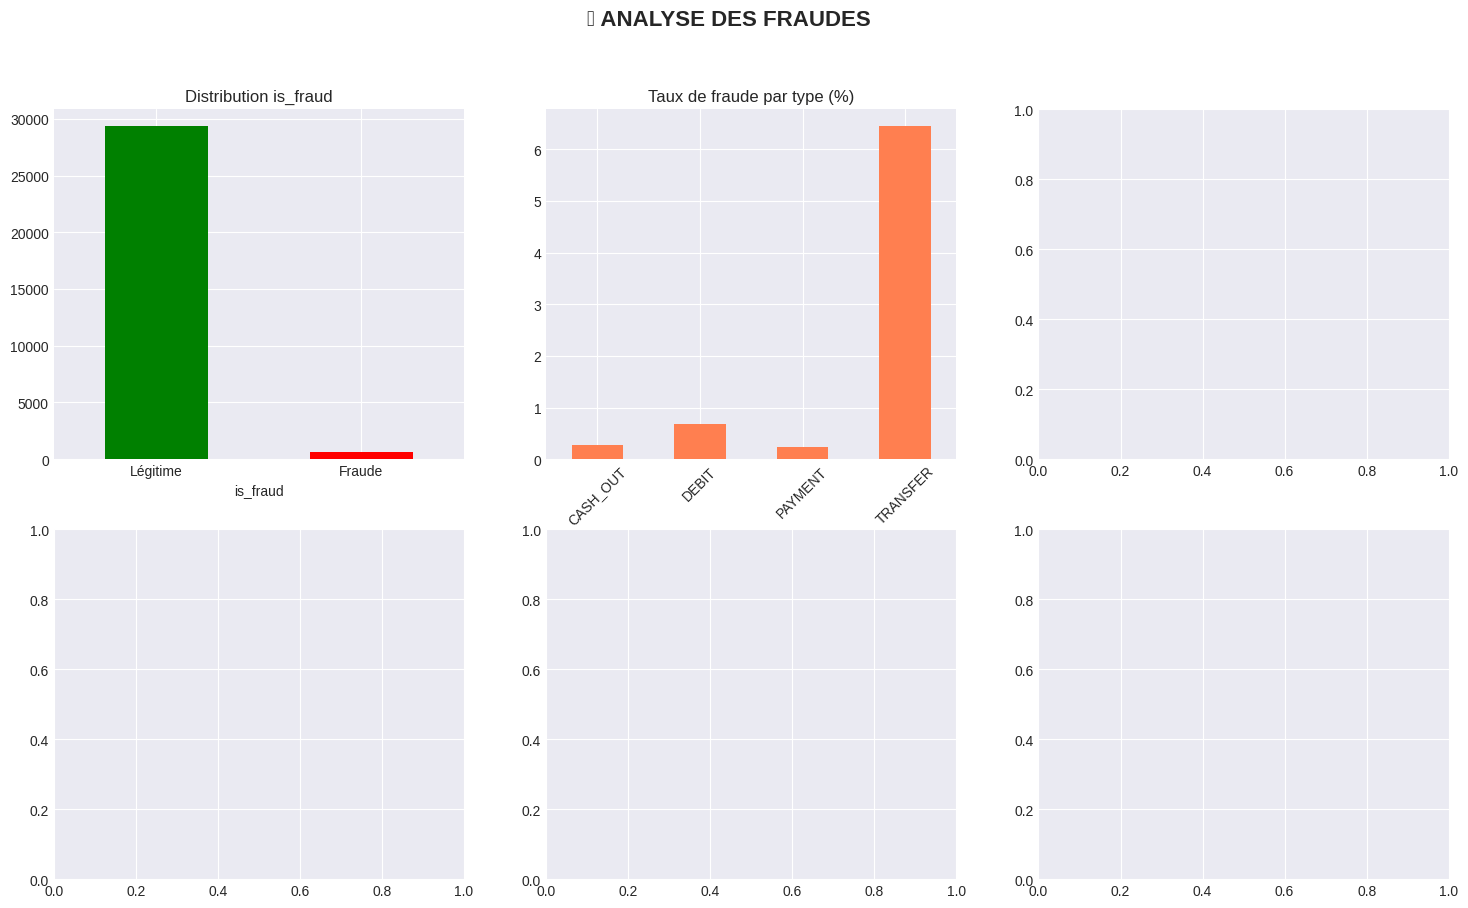

In [49]:
# ============================================
# 4️⃣ VISUALISATIONS
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('🔍 ANALYSE DES FRAUDES', fontsize=16, fontweight='bold')

# 1. Distribution de la cible
fraud_counts.plot(kind='bar', ax=axes[0,0], color=['green','red'])
axes[0,0].set_title('Distribution is_fraud')
axes[0,0].set_xticklabels(['Légitime', 'Fraude'], rotation=0)

# 2. Fraudes par type de transaction
fraud_by_type = train_df.groupby('type')['is_fraud'].agg(['sum','count'])
fraud_by_type['rate'] = (fraud_by_type['sum'] / fraud_by_type['count']) * 100
fraud_by_type['rate'].plot(kind='bar', ax=axes[0,1], color='coral')
axes[0,1].set_title('Taux de fraude par type (%)')
axes[0,1].tick_params(axis='x', rotation=45)

In [51]:
# 3. Distribution des montants (méthode robuste)
legitimate = train_df[train_df['is_fraud']==0]['amount']
fraud = train_df[train_df['is_fraud']==1]['amount']

axes[0,2].hist(legitimate, bins=50, alpha=0.6, label='Légitime', color='green')
axes[0,2].hist(fraud, bins=50, alpha=0.6, label='Fraude', color='red')
axes[0,2].set_title('Distribution des montants')
axes[0,2].set_xlabel('Montant (MGA)')
axes[0,2].legend()
axes[0,2].set_yscale('log')

In [52]:
# 4. Fraudes par âge
train_df.boxplot(column='age', by='is_fraud', ax=axes[1,0])
axes[1,0].set_title('Âge selon is_fraud')
axes[1,0].set_xlabel('is_fraud')

Text(0.5, 4.444444444444448, 'is_fraud')

In [53]:
# 5. Fraudes dans le temps
fraud_by_step = train_df.groupby('step')['is_fraud'].mean() * 100
axes[1,1].plot(fraud_by_step.index, fraud_by_step.values, color='darkred', linewidth=2)
axes[1,1].set_title('Évolution temporelle des fraudes')
axes[1,1].set_xlabel('Step (heures)')
axes[1,1].set_ylabel('Fraud Rate (%)')
axes[1,1].grid(True, alpha=0.3)

In [54]:
# 6. Corrélation
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
corr_matrix = train_df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            ax=axes[1,2], center=0, cbar_kws={'shrink': 0.8})
axes[1,2].set_title('Matrice de corrélation')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [55]:
# ============================================
# 5️⃣ FEATURE ENGINEERING
# ============================================
# Feature ingineering
print("\n" + "="*60)
print("🔧 FEATURE ENGINEERING")
print("="*60)

def create_features(df):
    """Créer de nouvelles features pertinentes"""
    df = df.copy()

    # ===== FEATURES TEMPORELLES =====
    # Step 1 = Lundi 00h-01h
    df['hour_of_day'] = (df['step'] - 1) % 24
    df['day_of_week'] = ((df['step'] - 1) // 24) % 7
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['is_night'] = (df['hour_of_day'] < 6).astype(int)  # 00h-06h
    df['is_late_night'] = ((df['hour_of_day'] >= 22) | (df['hour_of_day'] < 6)).astype(int)

    # Période de la journée
    df['time_period'] = pd.cut(df['hour_of_day'],
                                bins=[0, 6, 12, 18, 24],
                                labels=[0, 1, 2, 3],  # Night, Morning, Afternoon, Evening
                                include_lowest=True).astype(int)

    # ===== FEATURES SUR LES MONTANTS =====
    df['amount_log'] = np.log1p(df['amount'])
    df['amount_squared'] = df['amount'] ** 2
    df['amount_sqrt'] = np.sqrt(df['amount'])

    # Montant élevé (au-dessus du 90e percentile)
    amount_90 = df['amount'].quantile(0.90)
    df['is_high_amount'] = (df['amount'] > amount_90).astype(int)

    # ===== FEATURES SUR L'ÂGE =====
    df['age_squared'] = df['age'] ** 2
    df['is_senior'] = (df['age'] >= 60).astype(int)
    df['is_young'] = (df['age'] <= 25).astype(int)

    # ===== INTERACTIONS =====
    df['night_high_amount'] = df['is_night'] * df['is_high_amount']
    df['weekend_high_amount'] = df['is_weekend'] * df['is_high_amount']

    return df

# Appliquer le feature engineering
train_df = create_features(train_df)
test_df = create_features(test_df)

print(f"✅ Nouvelles features créées!")
print(f"📊 Train shape: {train_df.shape}")
print(f"📊 Test shape: {test_df.shape}")


🔧 FEATURE ENGINEERING
✅ Nouvelles features créées!
📊 Train shape: (30000, 22)
📊 Test shape: (10000, 21)


In [56]:
# ============================================
# 6️⃣ PRÉPARATION DES DONNÉES
# ============================================
# Colonnes à exclure
exclude_cols = ['transaction_id', 'customer_id', 'is_fraud']

# Séparer features et target
X = train_df.drop(columns=exclude_cols)
y = train_df['is_fraud']

X_test_final = test_df.drop(columns=['transaction_id', 'customer_id'], errors='ignore')

# Encoder la colonne 'type' (catégorielle)
X = pd.get_dummies(X, columns=['type'], drop_first=True)
X_test_final = pd.get_dummies(X_test_final, columns=['type'], drop_first=True)

# Aligner les colonnes du test avec le train
X_test_final = X_test_final.reindex(columns=X.columns, fill_value=0)

print(f"✅ Features préparées: {X.shape[1]} colonnes")

✅ Features préparées: 21 colonnes


In [57]:
# ============================================
# 7️⃣ SPLIT TRAIN/VALIDATION (CORRECTION!)
# ============================================

# ⚠️ IMPORTANT: Split AVANT la standardisation (pas de data leakage)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ X_train: {X_train.shape}, X_val: {X_val.shape}")
print(f"✅ Distribution y_train:\n{y_train.value_counts(normalize=True)}")


✅ X_train: (24000, 21), X_val: (6000, 21)
✅ Distribution y_train:
is_fraud
0    0.980167
1    0.019833
Name: proportion, dtype: float64


In [58]:
# ============================================
# 8️⃣ STANDARDISATION (APRÈS LE SPLIT!)
# ============================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit sur train seulement
X_val_scaled = scaler.transform(X_val)          # Transform sur val
X_test_scaled = scaler.transform(X_test_final)  # Transform sur test

print("✅ Standardisation appliquée correctement!")

✅ Standardisation appliquée correctement!



🎯 BASELINE: RÉGRESSION LOGISTIQUE

📊 RÉSULTATS BASELINE:
              precision    recall  f1-score   support

    Légitime       1.00      0.86      0.92      5881
      Fraude       0.12      0.92      0.21       119

    accuracy                           0.86      6000
   macro avg       0.56      0.89      0.57      6000
weighted avg       0.98      0.86      0.91      6000


🎯 F1-Score Baseline: 0.2095


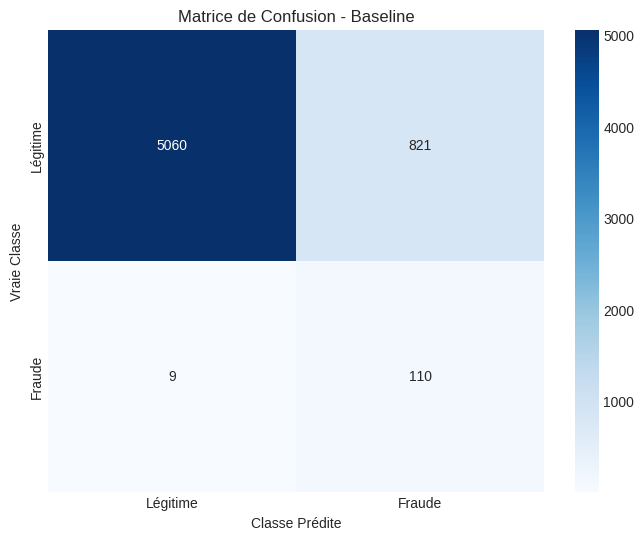

In [59]:
# 9️⃣ BASELINE: RÉGRESSION LOGISTIQUE
# ============================================

print("\n" + "="*60)
print("🎯 BASELINE: RÉGRESSION LOGISTIQUE")
print("="*60)

# Modèle avec class_weight pour gérer le déséquilibre
baseline_model = LogisticRegression(max_iter=1000,
                                     class_weight='balanced',
                                     random_state=42)

baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_val_scaled)

# Évaluation
print("\n📊 RÉSULTATS BASELINE:")
print(classification_report(y_val, y_pred_baseline,
                           target_names=['Légitime', 'Fraude']))

baseline_f1 = f1_score(y_val, y_pred_baseline)
print(f"\n🎯 F1-Score Baseline: {baseline_f1:.4f}")

# Matrice de confusion
cm_baseline = confusion_matrix(y_val, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Légitime', 'Fraude'],
            yticklabels=['Légitime', 'Fraude'])
plt.title('Matrice de Confusion - Baseline')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()



🚀 MODÈLE AVANCÉ: RANDOM FOREST + SMOTE
✅ SMOTE appliqué: (24000, 21) → (47048, 21)

📊 RÉSULTATS RANDOM FOREST:
              precision    recall  f1-score   support

    Légitime       1.00      0.96      0.98      5881
      Fraude       0.29      0.88      0.44       119

    accuracy                           0.96      6000
   macro avg       0.65      0.92      0.71      6000
weighted avg       0.98      0.96      0.97      6000


🎯 F1-Score Random Forest: 0.4421
📈 Amélioration: 0.2326 (111.0%)


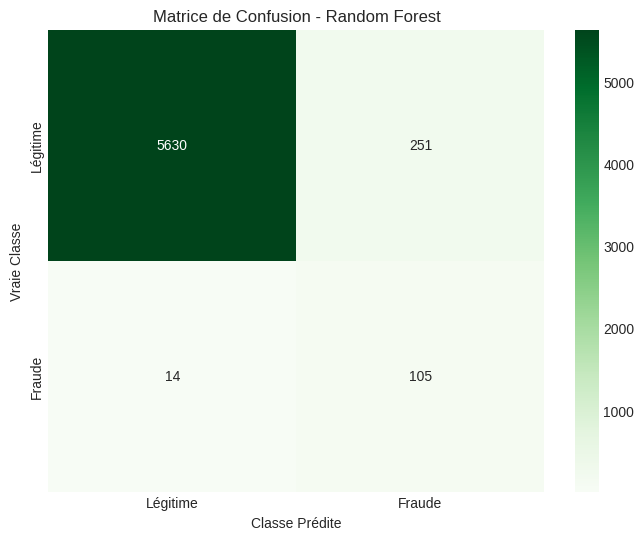

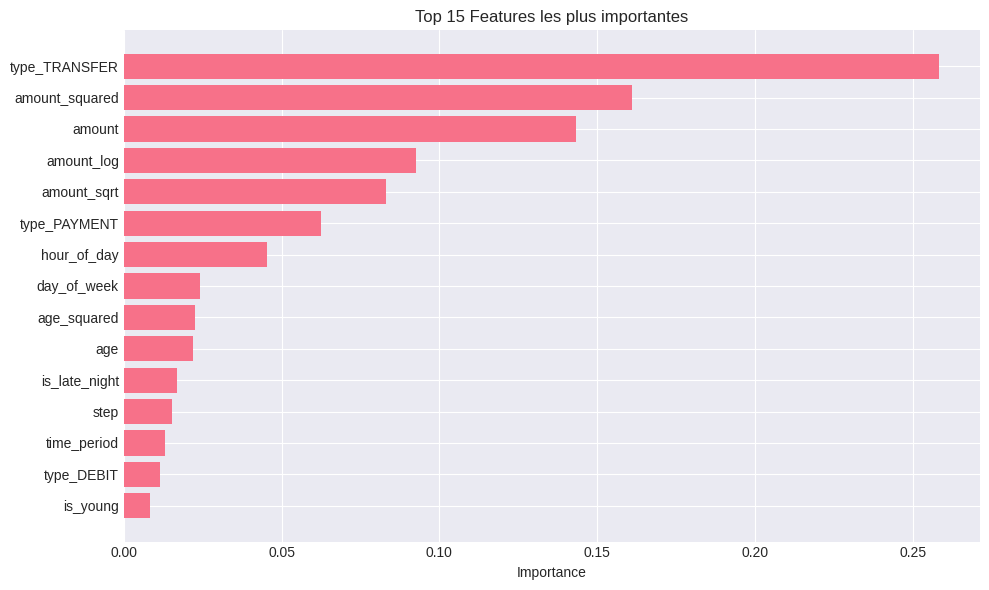


🔝 Top 10 Features:
           feature  importance
20   type_TRANSFER    0.258352
10  amount_squared    0.160983
1           amount    0.143238
9       amount_log    0.092610
11     amount_sqrt    0.083112
19    type_PAYMENT    0.062474
3      hour_of_day    0.045280
4      day_of_week    0.024009
13     age_squared    0.022432
2              age    0.021899


In [60]:
# 🔟 MODÈLE AVANCÉ: RANDOM FOREST + SMOTE
# ============================================

print("\n" + "="*60)
print("🚀 MODÈLE AVANCÉ: RANDOM FOREST + SMOTE")
print("="*60)

# Appliquer SMOTE sur le train set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"✅ SMOTE appliqué: {X_train_scaled.shape} → {X_train_balanced.shape}")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100,
                                  max_depth=15,
                                  min_samples_split=10,
                                  min_samples_leaf=5,
                                  class_weight='balanced',
                                  random_state=42,
                                  n_jobs=-1)

rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_val_scaled)

# Évaluation
print("\n📊 RÉSULTATS RANDOM FOREST:")
print(classification_report(y_val, y_pred_rf,
                           target_names=['Légitime', 'Fraude']))

rf_f1 = f1_score(y_val, y_pred_rf)
print(f"\n🎯 F1-Score Random Forest: {rf_f1:.4f}")
print(f"📈 Amélioration: {(rf_f1 - baseline_f1):.4f} ({(rf_f1/baseline_f1 - 1)*100:.1f}%)")

# Matrice de confusion
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Légitime', 'Fraude'],
            yticklabels=['Légitime', 'Fraude'])
plt.title('Matrice de Confusion - Random Forest')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Features les plus importantes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n🔝 Top 10 Features:")
print(feature_importance.head(10))

In [61]:
# ============================================
# 1️⃣1️⃣ GÉNÉRER SUBMISSION.CSV
# ============================================

print("\n" + "="*60)
print("📝 GÉNÉRATION DU FICHIER SUBMISSION")
print("="*60)

# Choisir le meilleur modèle (comparaison F1-Score)
if rf_f1 > baseline_f1:
    print(f"✅ Meilleur modèle: Random Forest (F1={rf_f1:.4f})")
    final_model = rf_model
    final_predictions = final_model.predict(X_test_scaled)
else:
    print(f"✅ Meilleur modèle: Baseline (F1={baseline_f1:.4f})")
    final_model = baseline_model
    final_predictions = final_model.predict(X_test_scaled)

# Créer le DataFrame de soumission
submission = pd.DataFrame({
    'transaction_id': test_df['transaction_id'],
    'is_fraud': final_predictions
})

# Sauvegarder
submission.to_csv('submission.csv', index=False)

print(f"\n✅ Fichier submission.csv généré!")
print(f"📊 Fraudes prédites: {final_predictions.sum()} ({final_predictions.sum()/len(final_predictions)*100:.2f}%)")
print(f"\n📁 Aperçu:")
print(submission.head(10))

# Télécharger le fichier
from google.colab import files
files.download('submission.csv')


📝 GÉNÉRATION DU FICHIER SUBMISSION
✅ Meilleur modèle: Random Forest (F1=0.4421)

✅ Fichier submission.csv généré!
📊 Fraudes prédites: 622 (6.22%)

📁 Aperçu:
                         transaction_id  is_fraud
0  f9d47afa-6e9f-45a1-a443-afb5132e9986         0
1  a3159433-df38-44d2-b6e1-3920b6f2a42f         0
2  27b30f3c-7688-489f-9c77-d70981bf1a05         1
3  c3566535-87b7-40d5-ac21-7874a193af11         0
4  26ec3542-7f49-4252-b906-78157c647db8         0
5  263251d5-df93-4ee0-8beb-f392a062e777         1
6  9c9eb6d7-ad99-48aa-b87b-8256b00bbfe2         0
7  86a9f7cf-65fe-4d87-9f51-4bab9fdbabf7         0
8  5d69da88-fff8-48a4-8bc4-74353aa077e0         0
9  5455bbc4-2c84-4ee6-9678-5c142d790f54         0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>